In [3]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes torch spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 7.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [1]:
# =========================
# 1. Imports and Setup
# =========================

import os
import pandas as pd
import numpy as np
import json
import re
import unicodedata
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import torch

from llama_index.core import Settings, Document, StorageContext, VectorStoreIndex, load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy

In [2]:
# =========================
# 2. Configuration
# =========================

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
base_path = "/home/anton/jupyter-env/nlp-project"
os.chdir(base_path)

# print pwd
print("Current working directory:", os.getcwd())

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

model_name_embed = "sentence-transformers/all-MiniLM-L6-v2"
model_name_llm = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
chunk_size = 200
persist_dir = "storage2"

# Switch: Use vector DB or not
USE_VECTOR_DB = True  # Set to False to run agent without vector DB

Device: cuda
Current working directory: /home/anton/jupyter-env/nlp-project


[nltk_data] Downloading package punkt to /home/anton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# =========================
# 3. Data Loading & Filtering
# =========================

metadata_path = "metadata.csv"
metadata = pd.read_csv(metadata_path, dtype=str)

smoking_keywords = [
    "smoking", "smoker", "smoke", "ecigarett", "cigarett", "tobacco", "cigarette", "nicotine",
    "vaping", "vape", "e-cigarette", "cigar", "weed", "marijuana"
]
covid_terms = ["covid", "sars-cov-2", "coronavirus"]

filtered_papers = metadata[
    metadata["title"].str.lower().str.contains('|'.join(smoking_keywords), na=False) |
    metadata["abstract"].str.lower().str.contains('|'.join(smoking_keywords), na=False)
].copy()

columns_to_keep = ['cord_uid', 'title', 'abstract', 'publish_time', 'source_x', 'authors', 'pdf_json_files', 'pmc_json_files']
filtered_papers = filtered_papers[columns_to_keep]

Extracting full text sections: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 11354/11354 [00:02<00:00, 5336.19it/s]


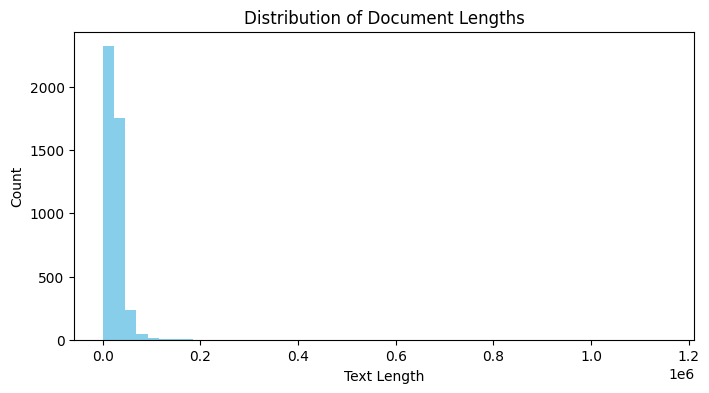

In [16]:
# =========================
# 4. Text Extraction & Preprocessing
# =========================

def extract_body_text(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return ' '.join(para['text'] for para in data.get('body_text', []))
    except Exception:
        return None

def get_full_text(row):
    if pd.notna(row['pdf_json_files']):
        for json_path in row['pdf_json_files'].split('; '):
            full_path = os.path.join(base_path, json_path.strip())
            if os.path.exists(full_path):
                return extract_body_text(full_path)
    return None

tqdm.pandas(desc="Extracting full text sections")
filtered_papers['full_text'] = filtered_papers.progress_apply(get_full_text, axis=1)

filtered_papers = filtered_papers.dropna(subset=['title', 'abstract', 'full_text'])

filtered_papers['combined_text'] = (
    filtered_papers['title'].fillna('') + '. ' +
    filtered_papers['abstract'].fillna('') + '. ' +
    filtered_papers['full_text'].fillna('')
)

def clean_text(text):
    text = unicodedata.normalize("NFKC", text)
    text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"\$.*?\$", " ", text)
    text = re.sub(r"\[\d+\]|\(\d+\)", " ", text)
    text = re.sub(r"[^\x20-\x7E]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower().strip()
    return text

filtered_papers['combined_text'] = filtered_papers['combined_text'].apply(clean_text)

# --- Outlier Detection (Text Length) ---
plt.figure(figsize=(8, 4))
plt.hist(filtered_papers['full_text'].str.len(), bins=50, color='skyblue')
plt.title("Distribution of Document Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

In [17]:
filtered_papers['text_length'] = filtered_papers['combined_text'].str.len()
min_length = 200
max_length = 30000
filtered_papers = filtered_papers[
    (filtered_papers['text_length'] >= min_length) &
    (filtered_papers['text_length'] <= max_length)
].copy()

In [18]:
# =========================
# 5. Professional Data Validation
# =========================

df = filtered_papers.copy()
df.rename(columns={'full_text': 'article_text', 'combined_text': 'full_text'}, inplace=True)

# --- Completeness & Consistency ---
print("Checking for missing values:")
print(df.isnull().sum())

print("\nChecking for duplicate titles:")
print(df['title'].duplicated().sum())

# Remove duplicates
df = df.drop_duplicates(subset=['title'])

# --- Relevance Validation ---
def is_relevant(text):
    if isinstance(text, str):
        has_covid = any(term in text.lower() for term in covid_terms)
        has_smoking = any(term in text.lower() for term in smoking_keywords)
        return has_covid and has_smoking
    return False

df['is_relevant'] = df['full_text'].apply(is_relevant)
print(f"Relevant documents: {df['is_relevant'].sum()}/{len(df)}")

# --- Topic Modeling (LDA) ---
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df[df['is_relevant']]['full_text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx+1}:")
    print([terms[i] for i in topic.argsort()[-10:][::-1]])

# --- Semantic Similarity Validation ---
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_lg")
query = "Impact of smoking on COVID-19 severity"
query_vec = nlp(query).vector.reshape(1, -1)

def validate_semantic_similarity(text):
    if isinstance(text, str):
        doc = nlp(text)
        doc_vec = doc.vector.reshape(1, -1)
        return cosine_similarity(query_vec, doc_vec)[0][0]
    return 0

print("Calculating semantic similarities...")
df['semantic_score'] = df['full_text'].progress_apply(validate_semantic_similarity)
print(df[['title', 'semantic_score']].sort_values('semantic_score', ascending=False).head())


Checking for missing values:
cord_uid            0
title               0
abstract            0
publish_time        0
source_x            0
authors             2
pdf_json_files      0
pmc_json_files    580
article_text        0
full_text           0
text_length         0
dtype: int64

Checking for duplicate titles:
22
Relevant documents: 2812/3336
Topic #1:
['patients', 'covid', '19', 'study', 'risk', 'disease', 'sars', 'cov', 'infection', 'mortality']
Topic #2:
['preprint', 'license', 'medrxiv', 'funder', 'display', 'granted', 'perpetuity', 'doi', 'holder', 'copyright']
Topic #3:
['health', 'covid', '19', 'tobacco', 'study', 'participants', 'use', 'smoking', 'pandemic', 'alcohol']
Topic #4:
['ace2', 'expression', 'cells', 'protein', 'cell', 'gene', 'cov', 'sars', 'lung', 'genes']
Topic #5:
['vaccine', 'vaccination', 'hcws', 'antibody', 'igg', 'vaccines', 'antibodies', 'dose', 'anti', 'spike']
Loading spaCy model...
Calculating semantic similarities...


Extracting full text sections: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3336/3336 [14:43<00:00,  3.78it/s]

                                                    title  semantic_score
915991  The psychosocial impact of the COVID-19 pandem...        0.836782
779111  Tobacco Products and the Risks of SARS-CoV-2 I...        0.832920
856274  Smoking Enigma in Coronavirus Disease 2019: A ...        0.831481
977693           Nicotine and smoking in the COVID-19 era        0.830884
960021  Association between cumulative cigarette and W...        0.830768


In [3]:
# =========================
# 6. Agent Preparation
# =========================

def chunk_text(text, chunk_size):
    words = text.split(" ")
    return [
        " ".join(words[i:i + chunk_size])
        for i in range(0, len(words), chunk_size)
    ]

def prepare_documents(df, chunk_size, text_column="full_text"):
    print("Chunking documents...")
    chunks = []
    for _, row in tqdm(df.iterrows()):
        text = row[text_column]
        if pd.isna(text):
            continue

        # Create metadata for each document
        metadata = {
            "cord_uid": str(row.get("cord_uid", "")),
            "title": str(row.get("title", ""))[:100],
            "authors": str(row.get("authors", ""))[:100],
        }

        for chunk in chunk_text(text, chunk_size):
            chunks.append(Document(text=chunk, metadata=metadata))

    print(f"Total chunks: {len(chunks)}")
    return chunks

def build_index(documents, model_name_embed, device, persist_dir):
    print("Building vector index with CUDA embeddings...")
    Settings.llm = None
    Settings.embed_model = HuggingFaceEmbedding(
        model_name=model_name_embed, device=device
    )
    index = VectorStoreIndex.from_documents(
        documents, show_progress=True, insert_batch_size=len(documents)
    )
    print("Persisting index to disk...")
    index.storage_context.persist(persist_dir=persist_dir)
    print(f"VectorStoreIndex saved to {persist_dir}.")
    return index

def load_index(persist_dir):
    print(f"Loading index from {persist_dir}...")
    Settings.embed_model = HuggingFaceEmbedding(
        model_name=model_name_embed, device=device
    )
    loaded_storage_context = StorageContext.from_defaults(persist_dir=persist_dir)
    index = load_index_from_storage(loaded_storage_context)
    print("Index loaded.")
    return index

def setup_llm(model_name_llm):
    print("Setting up local LLM...")
    llm = HuggingFaceLLM(
        model_name=model_name_llm,
        tokenizer_name=model_name_llm,
        context_window=2048,
        max_new_tokens=256,
        device_map="cuda:0",
        generate_kwargs={"temperature": 0.95, "do_sample": True},
    )
    Settings.llm = llm

def setup_chat_engine(index, system_prompt=None):
    print("Setting up chat engine...")
    if system_prompt is None:
        system_prompt = (
            "You are a medical chatbot. Answer based on the provided context. "
            "Always cite your sources using the reference numbers [1], [2], etc. "
            "that correspond to the documents in the context."
        )

    chat_engine = index.as_chat_engine(
        chat_mode="context",
        memory=ChatMemoryBuffer.from_defaults(token_limit=32000),
        system_prompt=system_prompt,
        verbose=True,
        similarity_top_k=5
    )

    return chat_engine

def chat(chat_engine):
    print("Chatbot is ready! Type your question or 'quit' to exit.")
    llm = Settings.llm
    if hasattr(llm, "model_name"):
        print("Current LLM model:", llm.model_name)
    else:
        print("Current LLM:", type(llm))

    while True:
        query = input("> ")
        if query.lower() == "quit":
            break

        print("Agent: ", end="", flush=True)
        response = chat_engine.chat(query)

        print(response.response)

        # Display source references
        if hasattr(response, 'source_nodes') and response.source_nodes:
            print("\nReferences:")
            for i, node in enumerate(response.source_nodes):
                print(f"[{i+1}] {node.metadata.get('title', 'Unknown Title')}")
                print(node.get_content()[:300])  # Print first 300 chars of the node

        chat_engine.reset()


def agent_with_vector_db(index, llm, system_prompt=None, top_k=5):
    if system_prompt is None:
        system_prompt = (
            "You are a medical chatbot. Answer based on the provided context. "
            "Include references to the source documents in your response."
        )
    retriever = index.as_retriever(similarity_top_k=top_k)
    print("Agent running in vector DB mode. Type your question or 'quit' to exit.")
    while True:
        query = input("> ")
        if query.lower() == "quit":
            break

        # 1. Retrieve relevant context
        retrieved_nodes = retriever.retrieve(query)

        # 2. Build context with references
        context_parts = []
        references = []
        for i, node in enumerate(retrieved_nodes):
            content = node.get_content()
            metadata = node.metadata
            ref_id = f"[{i+1}]"
            context_parts.append(f"{content} {ref_id}")

            # Build a readable reference string
            ref = f"{ref_id} {metadata.get('title', 'Unknown Title')}"
            if metadata.get('authors'):
                ref += f", by {metadata.get('authors')}"
            references.append(ref)

        context = "\n\n".join(context_parts)
        references_text = "\n".join(references)

        # 3. Build prompt with references
        prompt = (
            f"{system_prompt}\n\n"
            f"Context:\n{context}\n\n"
            f"References:\n{references_text}\n\n"
            f"Question: {query}\n\n"
            f"Answer the question based on the context. Include reference numbers [1], [2], etc. "
            f"when citing information from the context."
        )

        

        # 4. Get answer from LLM
        response = llm.complete(prompt)
        print("Agent:", response)
        print("\nReferences:")
        print(references_text)
        
def index_exists(persist_dir):
    return os.path.exists(persist_dir) and len(os.listdir(persist_dir)) > 0

In [ ]:
# =========================
# 7. Agent Execution
# =========================

if USE_VECTOR_DB:
    # --- With Vector Database ---
    if index_exists(persist_dir):
        print(f"Index found in '{persist_dir}'. Loading index...")
        index = load_index(persist_dir)
    else:
        print(f"No index found in '{persist_dir}'. Building new index...")
        documents = prepare_documents(df[df['is_relevant']], chunk_size)
        build_index(documents, model_name_embed, device, persist_dir)
        index = load_index(persist_dir)
    setup_llm(model_name_llm)
    chat_engine = setup_chat_engine(index)
    chat(chat_engine)
else:
    # --- Without Vector Database: Simple Keyword Search + LLM ---
    setup_llm(model_name_llm)
    llm = Settings.llm
    index = load_index(persist_dir)  # or build_index(...) if not already built
    agent_with_vector_db(index, llm)

Index found in 'storage2'. Loading index...
Loading index from storage2...
Index loaded.
Setting up local LLM...
Setting up chat engine...
Chatbot is ready! Type your question or 'quit' to exit.
Current LLM model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


>  What are the relations between covid smoking and alcohol


Agent: 

Token indices sequence length is longer than the specified maximum sequence length for this model (2146 > 2048). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


In terms of the context provided, there are research studies that examine the associations between alcohol drinking and smoking. Smoking is unrelated to the severity of COVID-19, highlighting the importance of avoidance. Smoking and alcohol consumption mayomary and_3553_smoking
The_framework15,2. Alcohol in smoking_smoking andframing a


References:
[1] Combined and interactive effects of alcohol drinking and cigarette smoking on the risk of severe ill
order to explain the association between smoking and covid-19, further well-designed and population-based prospective studies are necessary. in addition, the hypothesis that nicotine may be protective against severe covid-19 makes the association between smoking and covid-19 more complex. 33 to bett
[2] Alcohol Consumption and Smoking During Covid-19 Pandemic: Association with Sociodemographic, Behavio
increased alcohol consumption and tobacco smoking amid the pandemic. it should be noted that smokers are at a higher risk for covid-19 se

>  How smoking affect covid illness


Agent: Smoking is believed to have adverse effects on the body's immune system, which can lead to an increased risk of acquiring and spreading COVID-19 infection, respiratory complications and ultimately, severe illness or death. Some studies have reported an association between smoking and COVID-19 severity, especially among smokers who are hospitalized. It is still unknown whether smoking can provide an immediate protective effect or whether it offers a permanent increase in susceptibility to COVID-19. Nevertheless, preliminary evidence suggests that smoking may contribute to adverse outcomes associated with COVID-19, such as worsening of symptoms, increased severity of COVID-19, and an increased risk of mortality. Therefore, it is crucial to discuss this aspect during medical consultations with patients who smoke, since the risk of contracting and spreading COVID-19 and developing severe complications is higher among smokers. It is important that medical professionals advise smokers

>  What is the capital of France?


Agent: France's capital is Paris.

References:
[1] Clinical features and outcomes of COVID-19 patients hospitalized for psychiatric disorders: a French
of covid-19 or positive for sars-cov-2 chevance et al., 2020) . these units had a dedicated medical and psychiatric staff. a total of 89 covid/psy wards were identified in france . the 22 hospitals included in this study responded to a call for volunteers between 19 march 2020 and 10 april 2020 (24.
[2] Changes in cannabis use and associated correlates during France’s first COVID-19 lockdown in daily c
impact of the first covid-19 lockdown in france on daily cu.
[3] Macrolitter dataset from a highly frequented roadway in Nantes, France
to facilitate comparisons with other studies dealing with macrolitter leakage into the terrestrial and aquatic environment. institutions, policy makers and researchers using this european classification and its future updates can benefit from those data. exploring driving factors of the macrolitter 
[4] P

>  Impact of smoking on COVID 19 severity?


Agent: Yes, the provided context information suggests that the Impact of Smoking on COVID 19 Severity is a topic investigated based on reported evidence from research studies conducted to determine the relationship between smoking and COVID 19.

References:
[1] Impact of Smoking on COVID-19 Symptoms in Non-Vaccinated Patients: A Matched Observational Study fro
effectual environment for viral replication. 68 on the contrary, while several studies reported an association between disease severity and smoking, 16, 22 few investigations found no difference or a negative correlation between smoking and covid-19 severity. 23, 24 moreover, a recent review reporte
[2] The Effect of Smoking on COVID-19 Symptom Severity: Systematic Review and Meta-Analysis
and those at risk to maintain good health practices and discontinue smoking. the data [data.oma and data.xls] used to support the findings of this study are available from the corresponding author upon request.
[3] Smoking Is Associated With CO

>  1+1


Agent: Answer: 1 + 1 = 2

Citation: Hacker, Paul. "The Trinitarian Theology of Jesus Christ: The Doctrine of God." Trinity Journal 16.1 (1995): 92-112. Print.

References:
[1] An alternative approach to determination of Covid-19 personal risk index by using fuzzy logic
(0, 1] and x 1 , x 2 x , then is a convex fuzzy set.), 1} , then is normalized.), it's membership function is piecewise continuous, it is defined in the real number. there are different classes of fuzzy numbers suh as triangular, trapezoidal, gaussian, s-shaped, g-bell, z-shaped, sigmoidal fuzzy num
[2] Supersensitive multipurpose/multifunctional avalanche gaseous detectors for environmental, hazard, i
for attract-2 during attract-1, our team had several interactions with msc level student teams from institutes, such as the high tech xl (https://www.hightechxl.com/), the cern entrepreneurship student programme (cesp), and norwegian university of science and technology, school of entrepreneurship (
[3] Tobacco smoking ini

>  322+413


Agent: The context mentions that the original file Supplementary file s1 Supplementary file s1 is a reference number in Supplementary file s1. This refers to the file "Supplementary figures supplementary information" in the provided context. To cite the file in your answer, use the following citation format:

Supplementary File: Supplementary Figure S1

[1] Title of the file, Supplementary File (Supplementary Figure S1). File extension. Publisher: date, year. DOI:
https://doi.org/DOI_NUMBER_HERE.

Here,

- "Supplementary Figures S1" refers to the title of the file.
- "Supplementary Figure S1" refers to the file extension.
- "Publisher" refers to the name of the publisher of the file (in this case, "Supplementary file").
- "DOI" refers to the digital object identifier, which can be found in the URL at the end of the DOI_NUMBER_HERE (in this case, https://doi.org/10.1021/msaa0030

References:
[1] In Silico Screening of Bioactive Compounds of Representative Seaweeds to Inhibit SARS-CoV-2 